In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
problem = "Pendulum-v1"
env = gym.make(problem)

# This is needed to get the input size for the NN
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# This is needed to clip the actions within the legal boundaries
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# This is a noise used in the paper that introduced DDPG https://arxiv.org/pdf/1509.02971v6.pdf
# From what I understand, we can also use Gaussian or other noise without much difference,
# I left the noise as is
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # Its important to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size, replace=False)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
def policy(state, noise_object, use_noise=True):
    # For doing actions without added noise
    if not use_noise:     
        sampled_actions = tf.squeeze(actor_model(state)).numpy()
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        
        return [np.squeeze(legal_action)]
    else:
        sampled_actions = tf.squeeze(actor_model(state))
        noise = noise_object()
        # Adding noise to action
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

        return [np.squeeze(legal_action)]

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -1166.5130268429475
Episode * 1 * Avg Reward is ==> -1536.6956840485027
Episode * 2 * Avg Reward is ==> -1622.1710168627903
Episode * 3 * Avg Reward is ==> -1403.238325833018
Episode * 4 * Avg Reward is ==> -1367.408433234064
Episode * 5 * Avg Reward is ==> -1336.0829827288524
Episode * 6 * Avg Reward is ==> -1345.2592406806505
Episode * 7 * Avg Reward is ==> -1297.7536799739742
Episode * 8 * Avg Reward is ==> -1355.462054857927
Episode * 9 * Avg Reward is ==> -1327.0558127338393
Episode * 10 * Avg Reward is ==> -1303.5025077636994
Episode * 11 * Avg Reward is ==> -1347.4529934104892
Episode * 12 * Avg Reward is ==> -1350.096877243016
Episode * 13 * Avg Reward is ==> -1314.908664968503
Episode * 14 * Avg Reward is ==> -1338.816691791041
Episode * 15 * Avg Reward is ==> -1346.6339549447757
Episode * 16 * Avg Reward is ==> -1361.3416533548766
Episode * 17 * Avg Reward is ==> -1362.0522768016235
Episode * 18 * Avg Reward is ==> -1359.307785384177
Episode * 

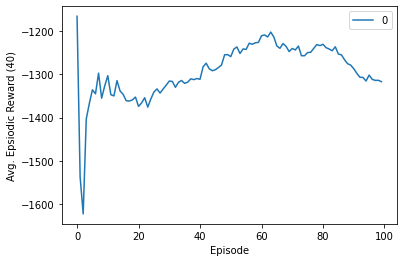

In [14]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

trial_times = 1

for trial in range(trial_times):
    
    #reset the networks
    actor_model = get_actor()
    critic_model = get_critic()

    target_actor = get_actor()
    target_critic = get_critic()

    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
    
    # add sublists for each trial
    avg_reward_list.append([])
    ep_reward_list.append([])
    
    for ep in range(total_episodes):

        prev_state = env.reset()
        episodic_reward = 0

        while True:
            # Uncomment this to see the Actor in action
            # But not in a python notebook.
            # env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = policy(tf_prev_state, ou_noise)
            # Recieve state and reward from environment.
            state, reward, done, info = env.step(action)

            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn()
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            # End this episode when `done` is True
            if done:
                break

            prev_state = state

        ep_reward_list[trial].append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[trial][-40:])
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        avg_reward_list[trial].append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
for idx, p in enumerate(avg_reward_list):
    plt.plot(p, label=str(idx))
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward (40)")
plt.legend()
plt.show()

In [9]:
# Save the weights
actor_model.save_weights("Weights/pendulum_actor.h5")
critic_model.save_weights("Weights/pendulum_critic.h5")

target_actor.save_weights("Weights/pendulum_target_actor.h5")
target_critic.save_weights("Weights/pendulum_target_critic.h5")